In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold

from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt

In [79]:
train_features = pd.read_csv('data/train_features.csv', index_col=['process_id'])
train_features['label'] = 0
test_features = pd.read_csv('data/test_features.csv', index_col=['process_id'])
test_features['label'] = 1

data = pd.concat([train_features, test_features], axis=0)

X = data.drop(['label', 'pipeline_L1', 'pipeline_L10', 'pipeline_L11', 'pipeline_L12', 
               'pipeline_L2', 'pipeline_L3', 'pipeline_L4', 'pipeline_L6', 'pipeline_L7', 
               'pipeline_L8', 'pipeline_L9'], axis=1)
y = data['label']

/home/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


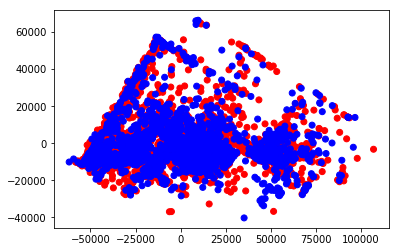

In [28]:
# PCA plot of train vs test data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.dropna(axis=1)) # Drop columns with na, since PCA cant handle that
colors = y.map({0: 'r', 1: 'b'})
plt.figure()
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=colors)
plt.show()

In [67]:
kf = KFold(n_splits=5, shuffle=True, random_state=1337)
vectors = []
shaps = []
for train_idx, test_idx in kf.split(X, y):
    X_train = X.iloc[train_idx, :]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx, :]
    y_test = y.iloc[test_idx]
    
    cat = CatBoostClassifier(iterations=1000, objective='CrossEntropy', random_seed=1337)
    cat.fit(X_train, y_train, verbose=100)
    
    predictions = cat.predict_proba(X_test)[:, 1]
    print('AUC = {}'.format(roc_auc_score(y_test, predictions)))
    
    for index, label, prediction in zip(X_test.index, y_test, predictions):
        vectors.append([index, label, prediction])
    
    explainer = shap.TreeExplainer(cat)
    shap_values = explainer.shap_values(X)
    shaps.append(shap_values)
    
prediction_df = pd.DataFrame(vectors, columns=['process_id', 'label', 'prediction'])

Learning rate set to 0.028303
0:	learn: 0.6730341	total: 184ms	remaining: 3m 3s
100:	learn: 0.3555062	total: 18.2s	remaining: 2m 41s
200:	learn: 0.3108137	total: 35.7s	remaining: 2m 21s
300:	learn: 0.2826361	total: 52.8s	remaining: 2m 2s
400:	learn: 0.2563644	total: 1m 10s	remaining: 1m 44s
500:	learn: 0.2350739	total: 1m 27s	remaining: 1m 27s
600:	learn: 0.2188944	total: 1m 45s	remaining: 1m 9s
700:	learn: 0.2058589	total: 2m 2s	remaining: 52.2s
800:	learn: 0.1944730	total: 2m 19s	remaining: 34.7s
900:	learn: 0.1855150	total: 2m 37s	remaining: 17.3s
999:	learn: 0.1765489	total: 2m 53s	remaining: 0us
AUC = 0.9559040529363111
Learning rate set to 0.028303
0:	learn: 0.6762169	total: 201ms	remaining: 3m 21s
100:	learn: 0.3567554	total: 18.2s	remaining: 2m 42s
200:	learn: 0.3128192	total: 35.5s	remaining: 2m 21s
300:	learn: 0.2876271	total: 52.4s	remaining: 2m 1s
400:	learn: 0.2611803	total: 1m 9s	remaining: 1m 43s
500:	learn: 0.2418679	total: 1m 26s	remaining: 1m 26s
600:	learn: 0.2257369

In [68]:
import shap

shap.initjs()

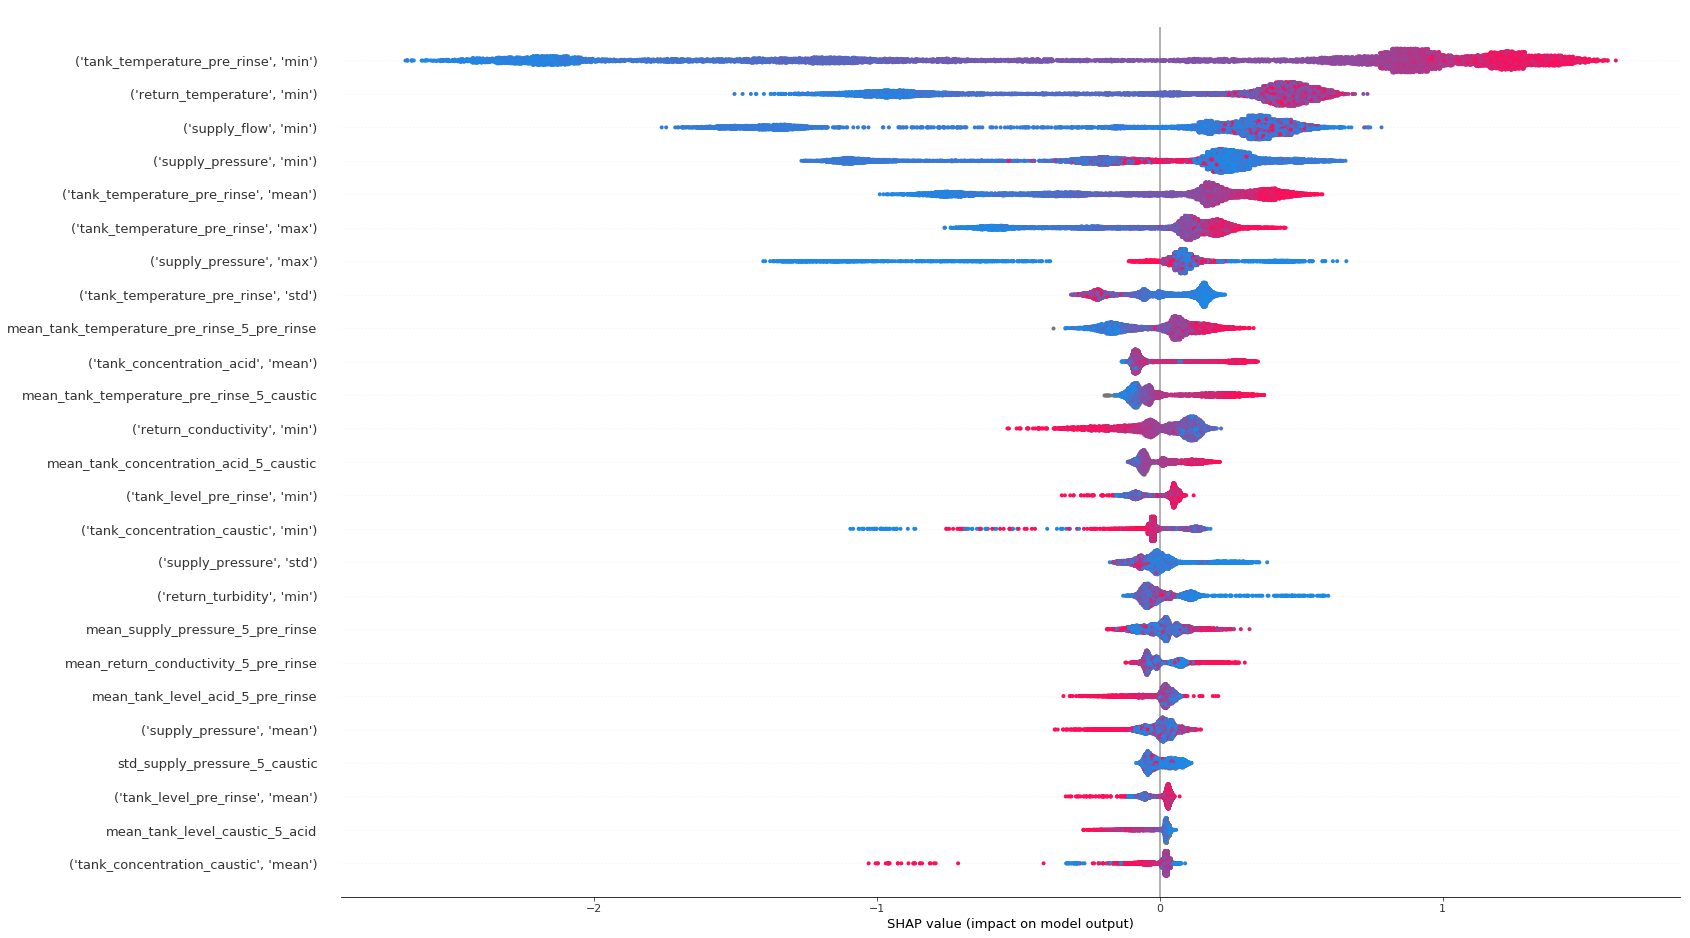

In [69]:
shap.summary_plot(np.mean(shaps, axis=0), X, max_display=25, 
                  auto_size_plot=True, show=False, color_bar=False)
plt.gcf().set_size_inches(24, 16)
plt.show()

In [80]:
# Now lets get the training samples with the highest out-of-sample prediction to be in the test set
# --> these will serve as our validation set
train_predictions = prediction_df[prediction_df['label'] == 0]
train_predictions = train_predictions.sort_values(by='prediction')
validation_processes = list(train_predictions.tail(int(0.1 * len(train_predictions)))['process_id'])
train_processes = list(set(train_predictions['process_id']) - set(validation_processes))

val_features = train_features.loc[validation_processes, :]
train_features = train_features.loc[train_processes, :]

train_features.to_csv('data/train_features.csv')
val_features.to_csv('data/val_features.csv')